# Design

Funtionality:
- Load data
- Run interpolation
- Return relevant data

Attributes:
- ZA specs (min/max)
- Nscale specs
- Map specs (size)

Methods:
- load_amc()
- interpolate()
- visualize()

In [1]:
import numpy as np

def DD_CubicHermiteSpline(eval_airmass, eval_nscale, df, reverse=False):
    '''Returns the interpolation of the data given an airmass and nscale value

    `reverse` - set True to reverse the order of operation
    '''

    from scipy.interpolate import CubicHermiteSpline
    from scipy.interpolate import RegularGridInterpolator

    Nscale_map = df.nscale.map[::2]
    Tb_scalar_field = df.data['TB_SCALAR_FIELD'][::2,::2]
    Nscale_jacobian = df.data['NSCALE_JACOBIAN'][::2,::2]
    airmass_map = df.airmass.map[::2]
    freq_map = df.data['FREQUENCY']
    airmass_jacobian = df.data['AIRMASS_JACOBIAN'][::2,::2]

    init_interp_func = CubicHermiteSpline(
        x=Nscale_map if reverse else airmass_map,
        y=Tb_scalar_field,
        dydx=Nscale_jacobian if reverse else airmass_jacobian,
        axis=0 if reverse else 1,
    )

    first_eval = init_interp_func(eval_nscale if reverse else eval_airmass)

    # Interpolate for nscale Jacobian at the chosen airmass
    jacob_interp_func = RegularGridInterpolator(
        points=(Nscale_map, airmass_map, freq_map),
        values=airmass_jacobian if reverse else Nscale_jacobian,
        method="linear",
    )

    x,y,z = np.meshgrid(
        eval_nscale if reverse else Nscale_map,
        airmass_map if reverse else eval_airmass,
        freq_map,
        indexing='ij',
    )

    mod_jacobian = jacob_interp_func(
        (x.flatten(),y.flatten(),z.flatten())
    ).reshape(x.shape)

    final_interp_func = CubicHermiteSpline(
        x=airmass_map if reverse else Nscale_map,
        y=first_eval,
        dydx=mod_jacobian,
        axis=1 if reverse else 0,
    )

    return final_interp_func(eval_airmass if reverse else eval_nscale)

In [3]:
from src.ozone import Ozone

min_nscale = -1         # -0.6
max_nscale = 1          # 0.6
nscale_points = 21
min_airmass = 1.001
max_airmass = 4.001
airmass_points = 11
freq_points = 240001
num_am_outputs = 5

# dender function __call__
# when object is called, specify pwv and zenith angle --> spit out model spectrum
# parse to extract pwv

df = Ozone(
    nscale=(min_nscale,max_nscale,nscale_points), 
    airmass=(min_airmass,max_airmass,airmass_points),
    frequency=freq_points
)

import numpy as np
data = np.zeros((df.nscale.points, df.airmass.points, df.frequency.points, num_am_outputs))
for idx, nscale in enumerate(df.nscale.map):
    for jdx, airmass in enumerate(df.airmass.map):
        filename = f'MaunaKea_Tb_Spectrum_{airmass:.3f}_{nscale:.2f}'
        data[idx,jdx] = np.load(f'/Users/namsonnguyen/repo/AM_Data/MaunaKea_SON50/Nscale21_AirMass11/{filename}.out')

df.data = data

eval_grid = DD_CubicHermiteSpline(
    eval_airmass=df.airmass.map,
    eval_nscale=df.nscale.map,
    df=df,
    reverse=False,
)

comparison_grid = ((eval_grid - df.data['TB_SCALAR_FIELD']) / df.data['TB_SCALAR_FIELD']) * 100

In [7]:
print(df(-1, -1))
print(df)

Will return the atmospheric model at specified argument
Ozone Object in development!


(180.0, 420.0)

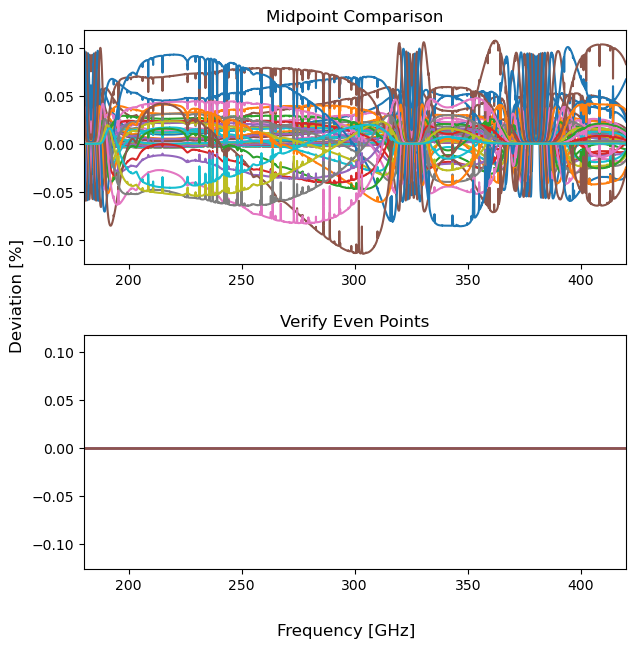

In [11]:
import matplotlib.pyplot as plt

# Plot results
fig, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(7, 7))
plt.subplots_adjust(wspace=0.4, hspace=0.3)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(1, df.nscale.points, 2):
    for jdx in range(1, df.airmass.points, 2):
        ax1.plot(freq_channels, comparison_grid[idx,jdx])

fig.supylabel("Deviation [%]")
fig.supxlabel("Frequency [GHz]")

ax1.set_title("Midpoint Comparison")
#ax1.set_ylim(-50, 50)
ax1.set_xlim(180, 420)

freq_channels = np.linspace(180, 420, freq_points)
for idx in range(0, df.nscale.points, 2):
    for jdx in range(0, df.airmass.points, 2):
        ax2.plot(freq_channels, comparison_grid[idx,jdx])

ax2.set_title("Verify Even Points")
ax2.set_xlim(180, 420)